In [41]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

import datetime


In [42]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation
import dipy.data as dpd
from sklearn.utils import class_weight

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import  Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


In [45]:
import bundlenet as bn

In [46]:
import dask.bag as db

In [47]:
ls /home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles

AF_L.trk             CCMid.trk  CST_R.trk   IFOF_L.trk
AF_R.trk             C_L.trk    F_L.trk     MCP.trk
CC_ForcepsMajor.trk  C_R.trk    F_R.trk     UF_L.trk
CC_ForcepsMinor.trk  CST_L.trk  IF0F_R.trk  UF_R.trk


In [48]:
bundle_files = sorted(glob('/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/*.trk'))

In [49]:
diff_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape=diff_img.shape[0:3]
vol_shape

(182, 218, 182)

In [50]:
bundle_files

['/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/AF_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/AF_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CCMid.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CC_ForcepsMajor.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CC_ForcepsMinor.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CST_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CST_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/C_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/C_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/F_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/F_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/IF0F_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/IFOF_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/MCP.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/UF_L.trk',
 '/home/ubuntu/A

In [51]:
#streamlines_all = bn.read_sl('/home/ubuntu/Atlas_in_MNI_Space_16_bundles/whole_brain/whole_brain_MNI.trk') 

In [52]:
'''streamlines_all_mni=[]
t=np.zeros([len(streamlines_all),3])
for i in range(len(streamlines_all)):
    tmp = streamlines_all[i]
    tmp2=np.zeros([len(tmp),3])
    tmp2[:,0] = tmp[:,0] * -1 + 90
    tmp2[:,1] = tmp[:,1] + 126
    tmp2[:,2] = tmp[:,2] + 72
    streamlines_all_mni.append(np.round(tmp2))
    t[i,0]=np.max(np.round(tmp2[:,0]))
    t[i,1]=np.max(np.round(tmp2[:,1]))
    t[i,2]=np.max(np.round(tmp2[:,2]))
'''

'streamlines_all_mni=[]\nt=np.zeros([len(streamlines_all),3])\nfor i in range(len(streamlines_all)):\n    tmp = streamlines_all[i]\n    tmp2=np.zeros([len(tmp),3])\n    tmp2[:,0] = tmp[:,0] * -1 + 90\n    tmp2[:,1] = tmp[:,1] + 126\n    tmp2[:,2] = tmp[:,2] + 72\n    streamlines_all_mni.append(np.round(tmp2))\n    t[i,0]=np.max(np.round(tmp2[:,0]))\n    t[i,1]=np.max(np.round(tmp2[:,1]))\n    t[i,2]=np.max(np.round(tmp2[:,2]))\n'

In [53]:
'''
streamline_all_bundle=np.zeros([len(streamlines_all),1])
n_streamlines = []
bundle_names = []
streamlines_seg = []
for f, fname in enumerate(bundle_files):
    print(f)
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    #streamlines_seg = streamlines_seg+streamlines
    for s_idx, s in enumerate(streamlines):
        for ss_idx, ss in enumerate(streamlines_all):
            if np.array_equal(s,ss):
                streamline_all_bundle[ss_idx]=f+1
                break
    n_streamlines.append(len(streamlines))
'''

"\nstreamline_all_bundle=np.zeros([len(streamlines_all),1])\nn_streamlines = []\nbundle_names = []\nstreamlines_seg = []\nfor f, fname in enumerate(bundle_files):\n    print(f)\n    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])\n    streamlines = bn.read_sl(fname) \n    #streamlines_seg = streamlines_seg+streamlines\n    for s_idx, s in enumerate(streamlines):\n        for ss_idx, ss in enumerate(streamlines_all):\n            if np.array_equal(s,ss):\n                streamline_all_bundle[ss_idx]=f+1\n                break\n    n_streamlines.append(len(streamlines))\n"

In [54]:
n_streamlines = []
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    n_streamlines.append(len(streamlines))


In [55]:
np.min(n_streamlines), len(n_streamlines)

(72, 16)

In [56]:
take_n_bundles = len(n_streamlines)
take_n_sl = np.min(n_streamlines)

test_perc=0.2
val_perc=0.2
size_slimage = 100

In [57]:
import imp  
imp.reload(bn)

#if op.exists('./subject1_bundles.npz'):
    # Read it from file:
   # loaded_from_file = np.load('./subject1_bundles.npz')
    #labels_test = loaded_from_file['labels_test']
    #labels_val = loaded_from_file['labels_val']
    #labels_train = loaded_from_file['labels_train']
    #data_test = loaded_from_file['data_test']
   # data_val = loaded_from_file['data_val']
    #data_train = loaded_from_file['data_train']
#else:
streamlines_loaded = db.from_sequence(bundle_files).map(bn.read_sl_mni).compute()
streamlines_processed = db.from_sequence(streamlines_loaded).map(bn.process_sl,take_n_sl,vol_shape,size_slimage,5).compute() 
data_train, data_test, data_val, labels_train, labels_test, labels_val = bn.partition_testtrain(test_perc, val_perc, streamlines_processed)
np.savez('./atlas_bundles', data_train=data_train, labels_train=labels_train, data_val=data_val, labels_val=labels_val, data_test=data_test, labels_test=labels_test)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


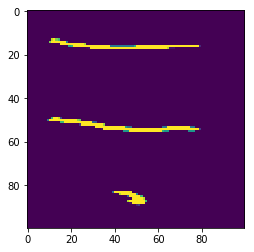

In [58]:
plt.imshow(streamlines_processed[5][1,:,:,0])

In [59]:
img_rows = size_slimage
img_cols = size_slimage
batch_size = 4
epochs = 5
num_classes = take_n_bundles
input_shape = (img_rows, img_cols,1)
pool_size = 2
kernel_size = 3

In [72]:
# define two groups of layers: feature (convolutions) from unet and classification (dense)
feature_layers = [
    Conv2D(64, kernel_size,
           padding='same',
           input_shape=input_shape),
    Activation('relu'),
     Conv2D(64, kernel_size,
           padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    
    Conv2D(128, kernel_size,
           padding='same'),
    Activation('relu'),
     Conv2D(128, kernel_size,
           padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    
    Conv2D(256, kernel_size,
           padding='same'),
    Activation('relu'),
     Conv2D(256, kernel_size,
           padding='same'),
    Activation('relu'),
    Conv2D(256, kernel_size,
           padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    
    Conv2D(512, kernel_size,
           padding='same'),
    Activation('relu'),
     Conv2D(512, kernel_size,
           padding='same'),
    Activation('relu'),
    Conv2D(512, kernel_size,
           padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    
    Conv2D(512, kernel_size,
           padding='same'),
    Activation('relu'),
     Conv2D(512, kernel_size,
           padding='same'),
    Activation('relu'),
    Conv2D(512, kernel_size,
           padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    
    Flatten()
]

classification_layers = [
    Dense(1024),
    Activation('relu'),
    Dense(5),
    Activation('softmax')
]

In [61]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [62]:
x_train.shape

(60000, 28, 28)

In [63]:
x_train_resize = np.zeros((len(x_train),size_slimage,size_slimage))
for i in range(len(x_train)):
    x_train_resize[i,:,:] = resize(x_train[i,:,:],(size_slimage,size_slimage))

In [64]:
x_test_resize = np.zeros((len(x_test),size_slimage,size_slimage))
for i in range(len(x_test)):
    x_test_resize[i,:,:] = resize(x_test[i,:,:],(size_slimage,size_slimage))

In [65]:
def train_model(model, train, test, num_classes):
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    t = now()
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    print('Training time: %s' % (now() - t))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

In [73]:
model = Sequential(feature_layers + classification_layers)

In [74]:
now = datetime.datetime.now

In [75]:
x_train_resize_lt5 = x_train_resize[y_train < 5]
y_train_lt5 = y_train[y_train < 5]
x_test_resize_lt5 = x_test_resize[y_test < 5]
y_test_lt5 = y_test[y_test < 5]

In [76]:
y_train_lt5.shape

(30596,)

In [ ]:
train_model(model,
            (x_train_resize_lt5[0:20000,:,:], y_train_lt5[0:20000]),
            (x_test_resize_lt5[0:20000,:,:], y_test_lt5[0:20000]),5)

x_train shape: (20000, 100, 100, 1)
20000 train samples
5139 test samples
Train on 20000 samples, validate on 5139 samples
Epoch 1/5
20000/20000 [==============================] - 526s 26ms/step - loss: 1.6102 - acc: 0.2213 - val_loss: 1.6092 - val_acc: 0.2209
Epoch 2/5
20000/20000 [==============================] - 525s 26ms/step - loss: 1.6081 - acc: 0.2236 - val_loss: 1.6083 - val_acc: 0.2209
Epoch 3/5
 9868/20000 [=============>................] - ETA: 4:11 - loss: 1.6083 - acc: 0.2216

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
filepath="checkpoints/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
#create checkpoints dir
training = model.fit(data_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_val, labels_val),
                     callbacks=callbacks_list,
                     class_weight=class_weights)

In [ ]:
model.load_weights("checkpoints/weights.best.hdf5")

In [ ]:
score = model.evaluate(data_test, labels_test, verbose=0)

In [ ]:
print(score)

In [ ]:
fig = bn.plot_accuracy(training)

In [ ]:
p = model.predict(data_test, batch_size=5)

In [ ]:
p_idx = np.argmax(p, axis=-1)
labels_test_idx = np.argmax(labels_test, axis=-1)

In [ ]:
bn.print_accuarcystats(p_idx,labels_test_idx)

In [ ]:
bn.plotconfusionmat(bundle_names, p_idx, labels_test_idx)

Cross-predict on *another subject*

In [ ]:
sub2_t1_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape_subj2=sub2_t1_img.shape[0:3]
vol_shape_subj2

In [ ]:
streamlines_all = bn.read_sl_mni('/home/ubuntu/recobundles/100307/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 

In [ ]:
'''import imp  
imp.reload(bn)
streamlines_processed=[]
for i in range(int(np.max(streamline_all_bundle))):
    print(i)
    indices = np.int_(np.where(streamline_all_bundle==i)[0])
    streamlines_tract = [streamlines_all[j] for j in indices]
    streamlines_processed_tract = bn.process_sl(streamlines_tract,take_n_sl,vol_shape,size_slimage,5)
    streamlines_processed.append(streamlines_processed_tract)
'''

In [ ]:
map_files = sorted(glob('/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
map_file_index = []
labels_subj2 = []
for m_idx, m in enumerate(map_files):
    tmp = np.load(m)
    map_file_index = np.append(map_file_index,tmp)
    labels_subj2 = np.append(labels_subj2,m_idx*np.ones([len(tmp),1]))
labels_subj2

In [ ]:
ind = range(len(streamlines_all))
ind = np.delete(ind,map_file_index)
np.random.shuffle(ind)
unlabeled_streamlines = ind[0:len(map_file_index)]
labels_subj2 = np.append(labels_subj2,16*np.ones([len(map_file_index),1]))

In [ ]:
labels_subj2

In [ ]:
np.append(map_file_index,unlabeled_streamlines)

In [ ]:
streamlines_all_sub = [streamlines_all[i] for i in np.int_(np.append(map_file_index,unlabeled_streamlines))]
len(streamlines_all_sub)
len(labels_subj2)

In [ ]:
import imp  
imp.reload(bn)
streamlines_all_processed = bn.process_sl(streamlines_all_sub,-1,vol_shape_subj2,size_slimage,5)

In [ ]:
tmp1 = np.load(map_files[0])
tmp2 = np.load(map_files[1])
tmp = np.append(tmp1,tmp2)
streamlines_bund1 = [streamlines_all[i] for i in np.int_(tmp)]
streamlines_bund1_processed = bn.process_sl(streamlines_bund1,-1,vol_shape_subj2,size_slimage,5)

In [ ]:
map_files

In [ ]:
plt.matshow(streamlines_all_processed[10000,:,:,0])

In [ ]:
p_subj2 = model.predict(streamlines_all_processed, batch_size=5)

In [ ]:
p_idx = np.argmax(p_subj2, axis=-1)
max(p_idx)

In [ ]:
bn.print_accuarcystats(p_idx[labels_subj2<16],labels_subj2[labels_subj2<16])

In [ ]:
plt.plot(p_subj2.max(axis=1))

In [ ]:
np.sum(labels_subj2==0)

In [ ]:
p_idx

In [ ]:
sum(p_idx[labels_subj2==0]==0)
len(p_idx[labels_subj2==0])

In [ ]:
bn.plotconfusionmat(bundle_names, p_idx, labels_subj2)

In [ ]:
p_error = p_subj2[~(p_idx == all_labels)]
p_correct = p_subj2[p_idx == all_labels]

In [ ]:
fig, ax = plt.subplots(1)
ax.hist(np.max(p_correct, -1), histtype='step', linewidth=2, normed=True, bins=10, label="Correct")
ax.hist(np.max(p_error, -1), histtype='step', linewidth=2, normed=True, bins=10, label="Incorrect")
ax.set_xlabel("Probability of chosen category")
ax.set_ylabel("Normalized frequency")
plt.legend(loc="upper left")

In [ ]:
dwi_img = nib.load('/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/sub-01_sess-01_dwi_b0.nii.gz')
vol_shape_dwi=dwi_img.shape
vol_shape_dwi

In [ ]:
import imp  
imp.reload(bn)

stan_loaded = db.from_sequence(["/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/clean_bundles/CST_R.trk"]).map(bn.read_sl).compute()
stan_streamlines_processed = db.from_sequence(stan_loaded).map(bn.process_sl,size_slimage,vol_shape_dwi,size_slimage,5).compute() 
tmp = stan_streamlines_processed[0]
plt.matshow(np.squeeze(np.sum(tmp,axis=0))) 
tmp1 = tmp[:,:,0,:]
plt.matshow(np.squeeze(tmp[10,:,:,:]))

In [ ]:
atlas_loaded = db.from_sequence([bundle_files[22]]).map(bn.read_sl).compute()
atlas_streamlines_processed = db.from_sequence(atlas_loaded).map(bn.process_sl,100,vol_shape,size_slimage,5).compute() 
tmp = atlas_streamlines_processed[0]
plt.matshow(np.squeeze(np.sum(tmp,axis=0)))
tmp1 = tmp[:,:,0,:]
plt.matshow(np.squeeze(tmp[1,:,:,:]))

In [ ]:
for i, j in enumerate(bundle_files):
    print(i, j)

In [ ]:
bundle_files_afq = glob('/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/clean_bundles/*.trk')

In [ ]:
streamlines_loaded_afq = db.from_sequence(bundle_files_afq).map(bn.read_sl).compute()

In [ ]:
del streamlines_processed_afq

In [ ]:
num_sl = 1000
streamlines_processed_afq = db.from_sequence(streamlines_loaded_afq).map(bn.process_sl,num_sl,vol_shape_dwi,size_slimage,5).compute() 

In [ ]:
len(streamlines_loaded_afq[19])

In [ ]:
all_streamlines_afq, all_labels_afq = bn.getdatafrombag(streamlines_processed_afq)

In [ ]:
p_afq = model.predict(all_streamlines_afq, batch_size=5)

In [ ]:
p_idx_afq = np.argmax(p_afq, axis=-1)

In [ ]:
bundle_names_afq = []
for fname in bundle_files_afq:
    bundle_names_afq.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])

In [ ]:
import statistics as stat

prob = np.max(p_afq,axis=-1)

for i in range(len(bundle_names_afq)):
    print("AFQ bundle= " + str(bundle_names_afq[i]))
    tmp = p_idx_afq[(num_sl*i):(num_sl-1)+(num_sl*i)]
    unique, counts = np.unique(tmp, return_counts=True)
    ctsinds = counts.argsort()
    sorted_unique = unique[ctsinds[::-1]]
    m1 = sorted_unique[0]
    m2 = sorted_unique[1]
    print("Most likely bundle= " + str(bundle_names[m1]))
    print("2nd Most likely bundle= " + str(bundle_names[m2]))
    tmp2 = prob[(num_sl*i):(num_sl-1)+(num_sl*i)]
    p = np.mean(tmp2)
    p2 = np.mean(tmp2[tmp==m1])
    print("Mean probability over all SLs= " + str(p))
    print("Mean probability over 'correct' SLs= " + str(p2))
    c = sum(tmp==m1)
    print("Fraction of SLs with most likely class= " + str(c/num_sl))
    c = sum(tmp==m2)
    print("Fraction of SLs with 2nd most likely class= " + str(c/num_sl))
    print("        ")

In [ ]:
unique, counts = np.unique(tmp, return_counts=True)
counts
ctsinds = counts.argsort()
sorted_unique = unique[ctsinds[::-1]]
print(counts)
print(unique)
sorted_unique

In [ ]:
prob.shape

In [ ]:
bundle_files_afq2 = glob('/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/bundles/*.trk')
streamlines_loaded_afq2 = db.from_sequence(bundle_files_afq2).map(bn.read_sl).compute()
num_sl = 1000
streamlines_processed_afq2 = db.from_sequence(streamlines_loaded_afq2).map(bn.process_sl,num_sl,vol_shape_dwi,size_slimage,1).compute() 
all_streamlines_afq2, all_labels_afq2 = bn.getdatafrombag(streamlines_processed_afq2)
p_afq = model.predict(all_streamlines_afq2, batch_size=5)
p_idx_afq = np.argmax(p_afq, axis=-1)
bundle_names_afq2 = []
for fname in bundle_files_afq2:
    bundle_names_afq2.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])

In [ ]:
import statistics as stat

prob = np.max(p_afq,axis=-1)

for i in range(len(bundle_names_afq2)):
    print("AFQ bundle= " + str(bundle_names_afq2[i]))
    tmp = p_idx_afq[(num_sl*i):(num_sl-1)+(num_sl*i)]
    m = stat.mode(tmp)
    print("Most likely bundle= " + str(bundle_names[m]))
    tmp2 = prob[(num_sl*i):(num_sl-1)+(num_sl*i)]
    p = np.mean(prob[(num_sl*i):(num_sl-1)+(num_sl*i)])
    p2 = np.mean(tmp2[tmp==m])
    print("Mean probability over all SLs= " + str(p))
    print("Mean probability over 'correct' SLs= " + str(p2))
    c = sum(tmp==m)
    print("Fraction of SLs with this most likely class= " + str(c/num_sl))
    print("        ")

In [ ]:
streamlines_loaded_afqall = db.from_sequence(["/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/sub-01_sess-01_dwiDTI_det_streamlines.trk"]).map(bn.read_sl).compute()

In [ ]:
sl = bn.read_sl("/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/sub-01_sess-01_dwiDTI_det_streamlines.trk")

In [ ]:
len(sl)

In [ ]:
streamlines_loaded_afqall = db.from_sequence([sl[0:10],sl[10:20]]).compute()

In [ ]:
streamlines_loaded_afqall = db.from_sequence([np.zeros([3,1]),np.zeros([3,1])]).compute()

In [ ]:
from AFQ.utils.parallel import parfor

In [ ]:
dwi_img = nib.load('/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/sub-01_sess-01_dwi_b0.nii.gz')
vol_shape_dwi=dwi_img.shape
vol_shape_dwi
num_sl=-1
size_slimage=100


In [ ]:
%time afq_all = parfor(bn.process_sl,[sl[i:i*30000] for i in range(10)],func_args=[num_sl,vol_shape_dwi,size_slimage,5],engine="dask")

In [ ]:
%time afq_all2 = bn.process_sl(sl[0:60000],num_sl,vol_shape_dwi,size_slimage,5)

In [ ]:
len(afq_all)

In [ ]:
plt.matshow(afq_all[0][1,:,:,:].squeeze()

In [ ]:
afq_all[0].shape